In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, balanced_accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/ML4HC/project1/part1'

Mounted at /content/drive
/content/drive/MyDrive/ML4HC/project1/part1


# Exploratory Data Analysis

In [3]:
# load dataset
train_val_data = pd.read_csv("train_val_split.csv")
test_data = pd.read_csv('test_split.csv')
print(f"Dataset shape: Train/Val {train_val_data.shape} - Test {test_data.shape}")

target = "HeartDisease"

# classification of original features
raw_cat_vars = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]
raw_num_vars = ["Age", "RestingBP", "Cholesterol", "Oldpeak"]


summary = pd.DataFrame(
    [np.round(train_val_data[target].agg(["count", "sum", "mean"]), 3),
    np.round(test_data[target].agg(["count", "sum", "mean"]), 3)],
    index = ["Train + Validation", "Test"]).\
        rename(columns = {"count":"Observations", "sum":"Positives", "mean": "Positive rate"})

summary.loc["Total", "Positive rate"] = summary["Positive rate"].mean(axis=0)
summary.loc["Total", ["Observations", "Positives"]] = summary[["Observations", "Positives"]].sum(axis=0)

display(summary)

# this dataframe will be used for EDA 
data = train_val_data.copy()

Dataset shape: Train/Val (734, 12) - Test (184, 12)


Observations  Positives  Positive rate
Train + Validation         734.0      398.0          0.542
Test                       184.0      110.0          0.598
Total                      918.0      508.0          0.570

In [4]:
data.sample(5)

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
216   54   M           ASY        130          242          0     Normal   
699   55   M           ASY        132          353          0     Normal   
196   55   M           ATA        145          326          0     Normal   
542   59   F           ASY        174          249          0     Normal   
37    43   M           ASY        120          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
216     91              Y      1.0     Flat             1  
699    132              Y      1.2     Flat             1  
196    155              N      0.0       Up             0  
542    143              Y      0.0     Flat             1  
37     120              Y      1.0     Flat             1

In [5]:
data.describe()

Age  RestingBP  Cholesterol   FastingBS       MaxHR     Oldpeak  \
count  734.000000  734.00000   734.000000  734.000000  734.000000  734.000000   
mean    53.523161  132.06267   197.588556    0.232970  136.167575    0.873978   
std      9.421110   18.61849   108.979439    0.423012   25.334552    1.082222   
min     29.000000    0.00000     0.000000    0.000000   60.000000   -2.000000   
25%     47.000000  120.00000   172.250000    0.000000  120.000000    0.000000   
50%     54.000000  130.00000   222.000000    0.000000  138.000000    0.500000   
75%     60.000000  140.00000   267.000000    0.000000  155.000000    1.500000   
max     77.000000  200.00000   529.000000    1.000000  195.000000    6.200000   

       HeartDisease  
count    734.000000  
mean       0.542234  
std        0.498553  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        1.000000  
max        1.000000

In [ ]:
# data types
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [ ]:
# missing values
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [ ]:
# number and rate of positives
data[target].agg(["count", "sum", "mean"])

count    734.000000
sum      398.000000
mean       0.542234
Name: HeartDisease, dtype: float64

## Visualizing features' distributions and positive rate per feature

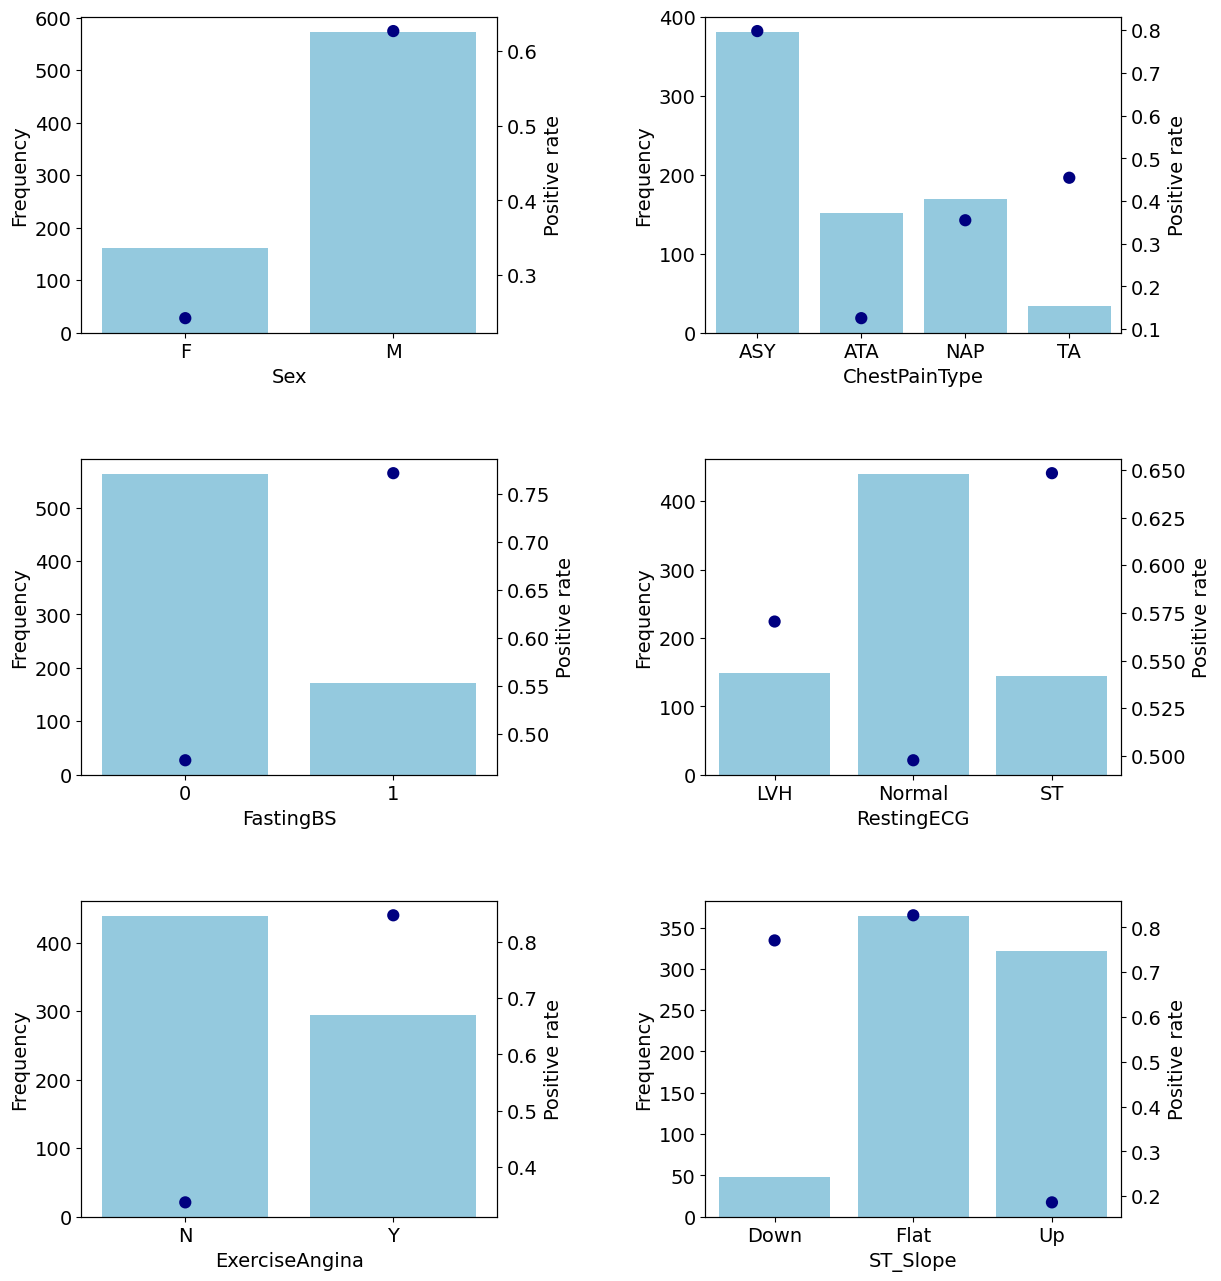

In [ ]:

plt.rc('font', size=14)

# for categorical features plot per feature a histogram + the positive rate per category
# this variable is a dummy and has no numerical value, for plotting convenience I convert it to string
data["FastingBS"] = data["FastingBS"].astype(int).astype(str)

fig = plt.figure(figsize=(13, 15))

for i, feature in enumerate(raw_cat_vars):

    gb = train_val_data.groupby(feature)[target].agg(["count", "sum", "mean"])

    ax1 = plt.subplot(3, 2, i+1)

    color = 'skyblue'
    sns.barplot(x=gb.index, y=gb['count'], ax=ax1, color=color)
    ax1.set_xlabel(feature)
    ax1.set_ylabel("Frequency")

    color = 'navy'
    ax2 = ax1.twinx()
    sns.pointplot(x=gb.index, y=gb['mean'], color=color, join=False)
    ax2.set_ylabel("Positive rate")
    
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.4)

plt.savefig('cat_vars_dist.png')

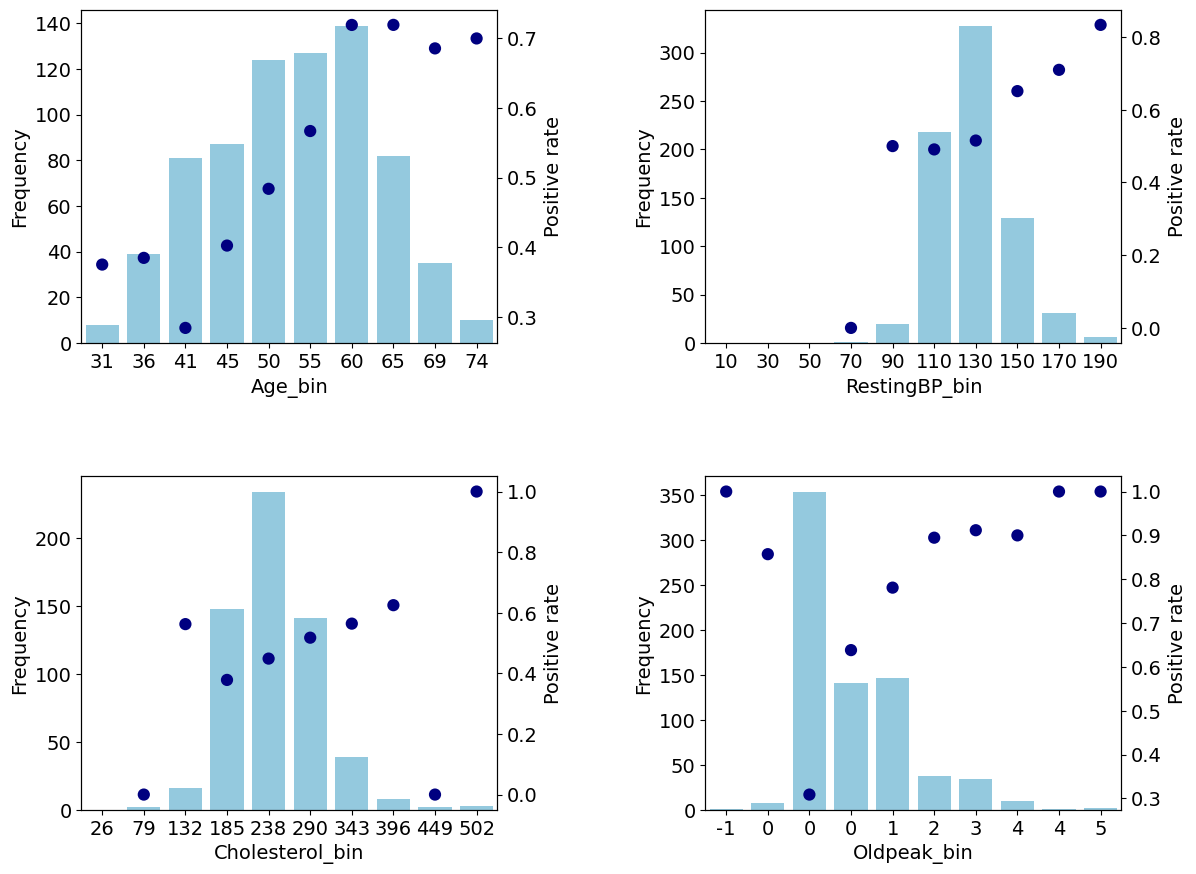

In [ ]:
# for all numerical features plot a histogram + the positive rate per bin
labels_dic = {}

for feature in raw_num_vars:

    heights, bins, _ = plt.hist(data[feature])
    bin_size = bins[1]-bins[0]
    labels = [int(x + bin_size/2) for x in bins[:-1]]
    plt.close()
    
    feature_bin = f"{feature}_bin"
    #data["Age_binned"] = pd.cut(data[var], bins=bins, labels=labels)
    data[feature_bin] = pd.cut(data[feature], bins=bins)

    labels_dic[feature_bin] = labels
    
fig = plt.figure(figsize=(13, 10))
    
for i, feature in enumerate(raw_num_vars):

    feature_bin = f"{feature}_bin"
    labels = labels_dic[feature_bin]
    gb = data.groupby(feature_bin)[target].agg(["count","mean"])

    ax1 = plt.subplot(2, 2, i+1)

    color = 'skyblue'
    ax1.set_xlabel(feature_bin)
    sns.barplot(x=gb.index, y=gb['count'], ax=ax1, color=color)
    ax1.set_ylabel("Frequency")
    ax1.set_xticklabels(labels)

    color = 'navy'
    ax2 = ax1.twinx()
    sns.pointplot(x=gb.index, y=gb['mean'], color=color, join=False)
    ax2.set_ylabel("Positive rate")
    ax2.set_xticklabels(labels)
    
    
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.4)
plt.savefig('num_vars_dist.png')

## Pairwise correlation matrix

In [ ]:
plt.rc('font', size=10)

<ipython-input-12-759e28e76053>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


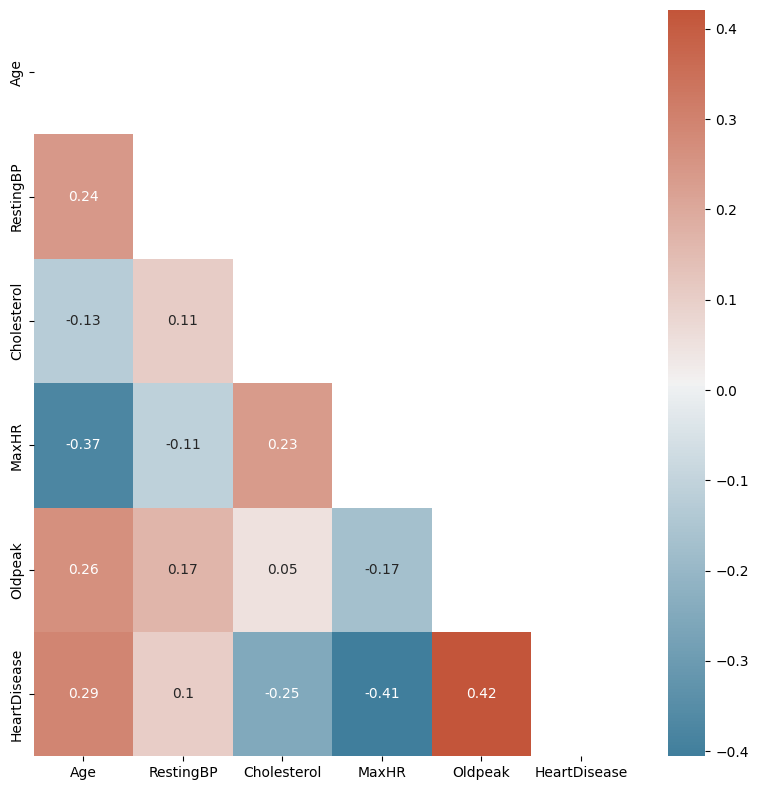

In [ ]:
corr = data.corr()
f, ax = plt.subplots(figsize=(8, 8))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

plt.tight_layout()
plt.savefig('correlation_matrix.png')

## Outliers

We look for outliers in the numerical features. For each numerical feature, we consider outliers those points that are 1.5 IQR under Q1 or 1.5 IQR over Q3. 


In [6]:
# identify outliers of numerical variables using the Inter Quantile Range

# exclude non-numerical features
data_num = data[raw_num_vars].copy()

# define quantiles q1 and q3 and Inter Quantile Range
q1 = data_num.quantile(.25)
q3 = data_num.quantile(.75)
iqr = q3 - q1

# create a summary table with outliers information for each numerical feature
outliers_summary = ((data_num < (q1 - 1.5 * iqr)) | (data_num > (q3 + 1.5 * iqr))).agg(["sum", "mean"]).T
outliers_summary["mean"] = outliers_summary["mean"]*100 
outliers_summary["lower_clip"] = q1 - 1.5 * iqr
outliers_summary["upper_clip"] = q3 + 1.5 * iqr

outliers_summary.round(1).rename(columns={"sum": "Outliers", "mean": "%"})

Outliers     %  lower_clip  upper_clip
Age               0.0   0.0        27.5        79.5
RestingBP        26.0   3.5        90.0       170.0
Cholesterol     148.0  20.2        30.1       409.1
Oldpeak          13.0   1.8        -2.2         3.8

Data points where Cholesterol=0: 19.2%


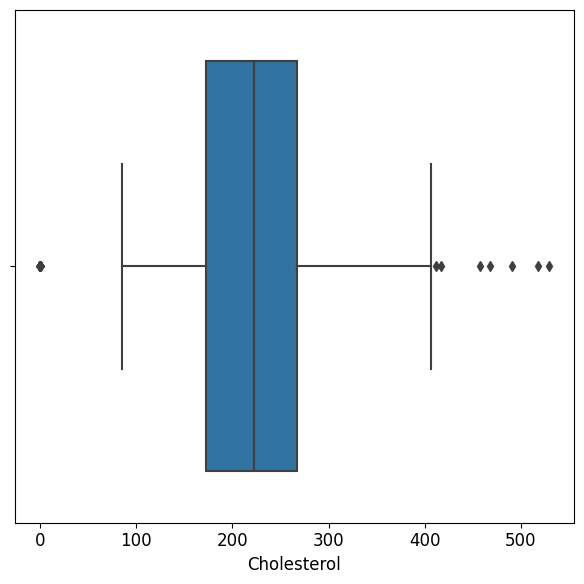

In [7]:
plt.rc('font', size=12)

fig, ax = plt.subplots(figsize=(6, 6))
# closer look at Cholesterol
sns.boxplot(x= data["Cholesterol"])

print(f"Data points where Cholesterol=0: {np.round((data['Cholesterol']== 0).mean(), 3)*100}%")
plt.tight_layout()
plt.savefig('cholesterol_outliers.png')

**Observations**:
- The number of outliers for *RestingBP*, *Oldpeak* is small enough to discard these data points. 
- In the case of *Cholesterol*, according to our outliers definition we observe a 19% of outliers but actually an 18.7% points for which *Cholesterol = 0*. This is relevant information so we will not discard these points.

It might also be a measurement error because its not possible to have 0mg/dl cholesterol

## Preprocess


- Removing outliers

- Creating dummies

- Standardizing feautres


In [8]:
# load datasets
train_val_data = pd.read_csv("train_val_split.csv")
test_data = pd.read_csv('test_split.csv')

target = "HeartDisease"

# compute mean cholesterol of training dataset
ix = train_val_data["Cholesterol"] != 0
mean_cholesterol = train_val_data.loc[ix, "Cholesterol"].mean()
print(mean_cholesterol)

244.56998313659358


In [9]:
def remove_outliers(df, features):
    """
    Removes data points from input df if they are outliers of input features

    input:
     - df: dataframe to be reduced inplace
     - features: list of features to detect and drop outliers from 
    """

    for feature in features:
        q1, q3 = df[feature].quantile(.25), df[feature].quantile(.75)
        iqr = q3 - q1
        df = df[((df[feature] < (q1 - 1.5 * iqr)) | (df[feature] > (q3 + 1.5 * iqr)))].copy()


def preprocess(data, cholesterol_0_subst):
    """

    Returns preprocessed dataframe:
    - Categorical dummies are converted to dummies
    - Cholesterol = 0 is substituted by chosen value (cholesterol_0_subst)
     
    """
    df = data.copy()
    # mean of Cholesterol value in training set, used to replace outliers

    # make a dummy from Cholesterol, as 20% of the patients have Cholesterol==0
    df['has_cholesterol'] = (df["Cholesterol"] > 0).astype(int)

    # drop one category from categorical variables with only 2 categories
    df["Sex"] = (df["Sex"]=="F").astype(int)
    df["ExerciseAngina"] = (df["ExerciseAngina"]=="Y").astype(int)

    df = pd.get_dummies(df)

    ix = df["Cholesterol"] == 0
    df["Cholesterol_clean"] = df["Cholesterol"].copy()
    df.loc[ix, "Cholesterol_clean"] = cholesterol_0_subst

    return df


# remove outliers from training set (not from test set)
outlier_features = ["Oldpeak", "RestingBP"]
remove_outliers(train_val_data, outlier_features)

# preprocess train and test set (df_train will later be splitted into train and validation sets)
df_train = preprocess(train_val_data, mean_cholesterol)
df_test = preprocess(test_data, mean_cholesterol)

# separate features and target for train+validation set
X_train_val = df_train[set(df_train.columns)-set([target])].copy()
y_train_val = df_train[target].copy()

# separate features and target for test set
X_test = df_test[set(df_test.columns)-set([target])].copy()
y_test = df_test[target].copy()


# Standardize features 
# the scaler is fitted only on training+validation set.
scaler = StandardScaler()
X_train_val = pd.DataFrame(scaler.fit_transform(X_train_val), columns=X_train_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

<ipython-input-9-e04fb0aaeb55>:52: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train_val = df_train[set(df_train.columns)-set([target])].copy()
<ipython-input-9-e04fb0aaeb55>:56: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test = df_test[set(df_test.columns)-set([target])].copy()




## Train/validation split

In [10]:
# split train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=.2, 
    random_state=3
    )

# create a summary of train, validation and test sets
display(
    pd.DataFrame(
    [y_train.agg(["count", "sum", "mean"]),
     y_val.agg(["count", "sum", "mean"]),
     y_test.agg(["count", "sum", "mean"])],
    index = ["train", "validation", "test"]).\
    rename(columns = {"count":"Observations", "sum":"Positives", "mean": "Positive rate"}))

Observations  Positives  Positive rate
train              587.0      322.0       0.548552
validation         147.0       76.0       0.517007
test               184.0      110.0       0.597826

# Feature Selection (with Lasso)

## Deal with "Cholesterol" features


- Feature set 1: Original features

- Feature set 2: Substitute "Cholesterol" feature by the preprocessed version of it "Colesterol_clean". Includes "has_cholesterol" dummy. 

- Feature set 3: Substitute "Cholesterol" feature by the preprocessed version of it "Colesterol_clean". Excludes "has_cholesterol" dummy.


In [25]:
chol_fs = ["Cholesterol_clean", "has_cholesterol", "Cholesterol"]
excluded_features = [["Cholesterol_clean", "has_cholesterol"], ["Cholesterol"], ["Cholesterol", "has_cholesterol"]]

for f in excluded_features:
    features = list(set(X_train) - set(f))
    # fit logistic lasso regression model
    clf = LogisticRegression(penalty="l1", solver="liblinear")
    clf.fit(X_train[features].copy(), y_train)

    # make predictions on validation set
    y_pred = clf.predict(X_val[features].copy())

    evaluation_metrics = pd.DataFrame()

    # calculate F1 score
    f1 = f1_score(y_val, y_pred)

    # calculate balanced accuracy
    ba = balanced_accuracy_score(y_val, y_pred)

    # fit and evaluate logistic lasso regression model with k_fold Cross Validation
    k_folds = 5
    rs = 123
    cv_f1 = cross_val_score(clf, X_train_val[features].copy(), y_train_val,
                            cv=k_folds, scoring="f1_macro")
    cv_ba = cross_val_score(clf, X_train_val[features].copy(), y_train_val,
                            cv=k_folds, scoring="balanced_accuracy")

    print(f"Included cholesterol features: {set(chol_fs)-set(f)}")
    print("Evaluation metrics on unique validation set:")
    print(f"- F1 score: {np.round(f1,3)}")
    print(f"- Balanced Accuracy score: {np.round(ba, 3)}")
    print("------")
    print(f"Evaluation metrics performing cross validation with {k_folds} folds:")
    print(f"- F1 score: {np.round(cv_f1,3)}, Mean : {np.round(np.mean(cv_f1), 3)}")
    print(f"- Balanced Accuracy score: {np.round(cv_ba, 3)}, Mean : {np.round(np.mean(cv_ba), 3)}")
    print("--------------------------------------------------------------------")
    print(" ")

Included cholesterol features: {'Cholesterol'}
Evaluation metrics on unique validation set:
- F1 score: 0.864
- Balanced Accuracy score: 0.848
------
Evaluation metrics performing cross validation with 5 folds:
- F1 score: [0.837 0.816 0.814 0.854 0.781], Mean : 0.82
- Balanced Accuracy score: [0.842 0.823 0.81  0.852 0.785], Mean : 0.822
--------------------------------------------------------------------
 
Included cholesterol features: {'Cholesterol_clean', 'has_cholesterol'}
Evaluation metrics on unique validation set:
- F1 score: 0.875
- Balanced Accuracy score: 0.862
------
Evaluation metrics performing cross validation with 5 folds:
- F1 score: [0.837 0.857 0.835 0.854 0.788], Mean : 0.834
- Balanced Accuracy score: [0.843 0.861 0.83  0.852 0.792], Mean : 0.836
--------------------------------------------------------------------
 
Included cholesterol features: {'Cholesterol_clean'}
Evaluation metrics on unique validation set:
- F1 score: 0.868
- Balanced Accuracy score: 0.855
-

Highest scores for Cross Validation are given with a feature set that includes the preprocessed features "Cholesterol_clean" and excludes "has_cholesterol" and the original feature "Cholesterol"  (F1 = 0.847, BA = 0.847).


## Select most important features

In [26]:
excluded_features = ["Cholesterol", "has_cholesterol"]

# fit logistic lasso regression model
clf = LogisticRegression(penalty="l1", solver="liblinear")

# fit and evaluate logistic lasso regression model with k_fold Cross Validation
k_folds = 5
cv_f1 = cross_val_score(clf, X_train_val.drop(columns=excluded_features), y_train_val, cv=k_folds, scoring="f1_macro")
cv_ba = cross_val_score(clf, X_train_val.drop(columns=excluded_features), y_train_val, cv=k_folds, scoring="balanced_accuracy")

print(f"Evaluation metrics performing cross validation with {k_folds} folds:")
print(f"- F1 score: {np.round(cv_f1,3)}, Mean : {np.round(np.mean(cv_f1), 3)}")
print(f"- Balanced Accuracy score: {np.round(cv_ba, 3)}, Mean : {np.round(np.mean(cv_ba), 3)}")

Evaluation metrics performing cross validation with 5 folds:
- F1 score: [0.884 0.85  0.851 0.861 0.788], Mean : 0.847
- Balanced Accuracy score: [0.886 0.855 0.846 0.857 0.791], Mean : 0.847


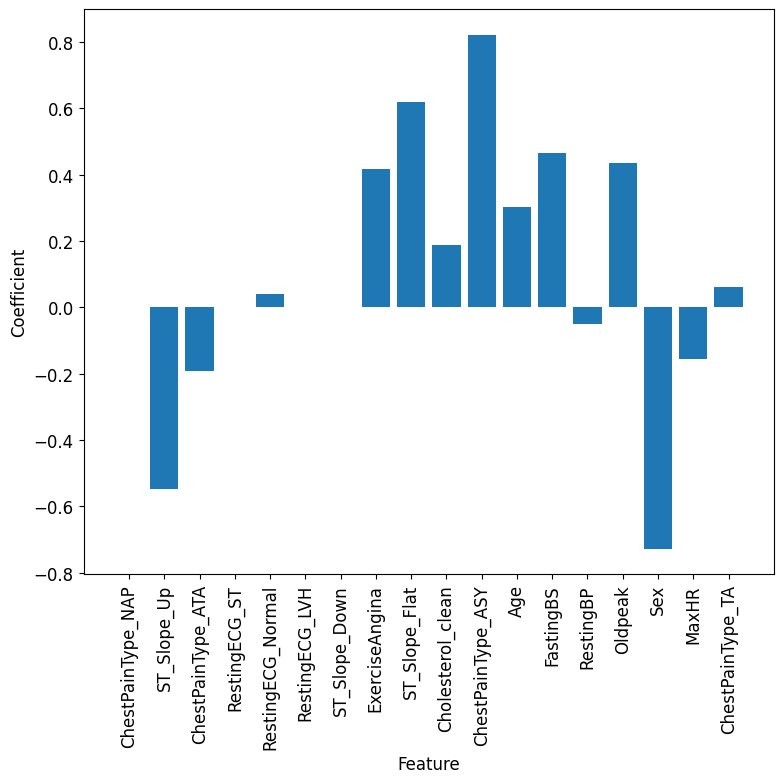

In [27]:
plt.rc('font', size=12)

# extract coefficients and corresponding feature names
clf.fit(X_train_val.drop(columns=excluded_features), y_train_val)
coef = clf.coef_.ravel()
feature_names = X_train_val.drop(columns=excluded_features).columns

feature_importance = pd.DataFrame(coef, feature_names, columns=["Importance"])
feature_importance["Absolute value"] = np.abs(feature_importance["Importance"])

# barplot of coefficients
plt.figure(figsize=(8, 8))
plt.bar(feature_names, coef)
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Coefficient")

plt.tight_layout()
plt.savefig('lasso_feature_importance.png')

In [28]:
top5_features = feature_importance.sort_values("Absolute value", ascending=False)[0:5].index.to_list()
top5_features

['ChestPainType_ASY', 'Sex', 'ST_Slope_Flat', 'ST_Slope_Up', 'FastingBS']

In [29]:
excluded_features = list(set(X_train) - set(top5_features))

# fit logistic lasso regression model
clf = LogisticRegression(penalty="l1", solver="liblinear")
clf.fit(X_train.drop(columns=excluded_features), y_train)

# make predictions on fixed validation set
y_pred = clf.predict(X_val.drop(columns=excluded_features))

# calculate f1 score and balanced accuracy
f1 = f1_score(y_val, y_pred)
ba = balanced_accuracy_score(y_val, y_pred)

# fit and evaluate logistic lasso regression model with k_fold Cross Validation
clf = LogisticRegression(penalty="l1", solver="liblinear")
k_folds = 5
cv_f1 = cross_val_score(clf, X_train_val.drop(columns=excluded_features), y_train_val, cv=k_folds, scoring="f1_macro")
cv_ba = cross_val_score(clf, X_train_val.drop(columns=excluded_features), y_train_val, cv=k_folds, scoring="balanced_accuracy")

print("Evaluation metrics on unique validation set:")
print(f"- F1 score: {np.round(f1,3)}")
print(f"- Balanced Accuracy score: {np.round(ba, 3)}")
print("------")
print(f"Evaluation metrics performing cross validation with {k_folds} folds:")
print(f"- F1 score: {np.round(cv_f1,3)}, Mean : {np.round(np.mean(cv_f1), 3)}")
print(f"- Balanced Accuracy score: {np.round(cv_ba, 3)}, Mean : {np.round(np.mean(cv_ba), 3)}")

Evaluation metrics on unique validation set:
- F1 score: 0.873
- Balanced Accuracy score: 0.862
------
Evaluation metrics performing cross validation with 5 folds:
- F1 score: [0.924 0.884 0.828 0.855 0.767], Mean : 0.852
- Balanced Accuracy score: [0.923 0.888 0.827 0.854 0.769], Mean : 0.852


The performance improves when fitting the model on just the 5 most important features. We thus opt for simplifying the model because this will improve interpretability and explainability.

## Final feature selection

In [30]:
# top 5 most important features according to Lasso coefficients. 
features = ['ChestPainType_ASY', 'Sex', 'ST_Slope_Flat', 'ST_Slope_Up', 'FastingBS']
X_train_val_fs = X_train_val[features].copy()
X_train_fs = X_train[features].copy()
X_val_fs = X_val[features].copy()
X_test_fs = X_test[features].copy()

# Lasso Regression

In [ ]:
# train decision tree classifier
clf = LogisticRegression(penalty="l1", solver="liblinear")
clf.fit(X_train_fs, y_train)

# make predictions on validation set
y_pred = clf.predict(X_val_fs)

# calculate f1 score and balanced accuracy
f1 = f1_score(y_val, y_pred)
ba = balanced_accuracy_score(y_val, y_pred)

# fit and evaluate logistic lasso regression model with k_fold Cross Validation
k_folds = 5
cv_f1 = cross_val_score(clf, X_train_val_fs, y_train_val, cv=k_folds, scoring="f1_macro")
cv_ba = cross_val_score(clf, X_train_val_fs, y_train_val, cv=k_folds, scoring="balanced_accuracy")

print("Evaluation metrics on unique validation set:")
print(f"- F1 score: {np.round(f1,3)}")
print(f"- Balanced Accuracy score: {np.round(ba, 3)}")
print("------")
print(f"Evaluation metrics performing cross validation with {k_folds} folds:")
print(f"- F1 score: {np.round(cv_f1,3)}, Mean : {np.round(np.mean(cv_f1), 3)}")
print(f"- Balanced Accuracy score: {np.round(cv_ba, 3)}, Mean : {np.round(np.mean(cv_ba), 3)}")

# make predictions on test set

clf.fit(X_train_val_fs, y_train_val)

y_pred = clf.predict(X_test_fs)

# calculate f1 score and balanced accuracy
f1 = f1_score(y_test, y_pred)
ba = balanced_accuracy_score(y_test, y_pred)

print("------")
print("Evaluation metrics on test set:")
print(f"- F1 score: {np.round(f1,3)}")
print(f"- Balanced Accuracy score: {np.round(ba, 3)}")

Evaluation metrics on unique validation set:
- F1 score: 0.873
- Balanced Accuracy score: 0.862
------
Evaluation metrics performing cross validation with 5 folds:
- F1 score: [0.924 0.884 0.828 0.855 0.767], Mean : 0.852
- Balanced Accuracy score: [0.923 0.888 0.827 0.854 0.769], Mean : 0.852
------
Evaluation metrics on test set:
- F1 score: 0.861
- Balanced Accuracy score: 0.821


# Decision Trees

In [ ]:
# train decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_fs, y_train)

# make predictions on validation set
y_pred = clf.predict(X_val_fs)

# calculate f1 score and balanced accuracy
f1 = f1_score(y_val, y_pred)
ba = balanced_accuracy_score(y_val, y_pred)

# fit and evaluate logistic lasso regression model with k_fold Cross Validation
k_folds = 5
cv_f1 = cross_val_score(clf, X_train_val_fs, y_train_val, cv=k_folds, scoring="f1_macro")
cv_ba = cross_val_score(clf, X_train_val_fs, y_train_val, cv=k_folds, scoring="balanced_accuracy")

print("Evaluation metrics on unique validation set:")
print(f"- F1 score: {np.round(f1,3)}")
print(f"- Balanced Accuracy score: {np.round(ba, 3)}")
print("------")
print(f"Evaluation metrics performing cross validation with {k_folds} folds:")
print(f"- F1 score: {np.round(cv_f1,3)}, Mean : {np.round(np.mean(cv_f1), 3)}")
print(f"- Balanced Accuracy score: {np.round(cv_ba, 3)}, Mean : {np.round(np.mean(cv_ba), 3)}")


# make predictions on test set
clf.fit(X_train_val_fs, y_train_val)
y_pred = clf.predict(X_test_fs)

# calculate f1 score and balanced accuracy
f1 = f1_score(y_test, y_pred)
ba = balanced_accuracy_score(y_test, y_pred)


print("------")
print("Evaluation metrics on test set:")
print(f"- F1 score: {np.round(f1,3)}")
print(f"- Balanced Accuracy score: {np.round(ba, 3)}")

Evaluation metrics on unique validation set:
- F1 score: 0.855
- Balanced Accuracy score: 0.825
------
Evaluation metrics performing cross validation with 5 folds:
- F1 score: [0.889 0.823 0.756 0.848 0.767], Mean : 0.817
- Balanced Accuracy score: [0.885 0.831 0.755 0.846 0.769], Mean : 0.817
------
Evaluation metrics on test set:
- F1 score: 0.848
- Balanced Accuracy score: 0.803


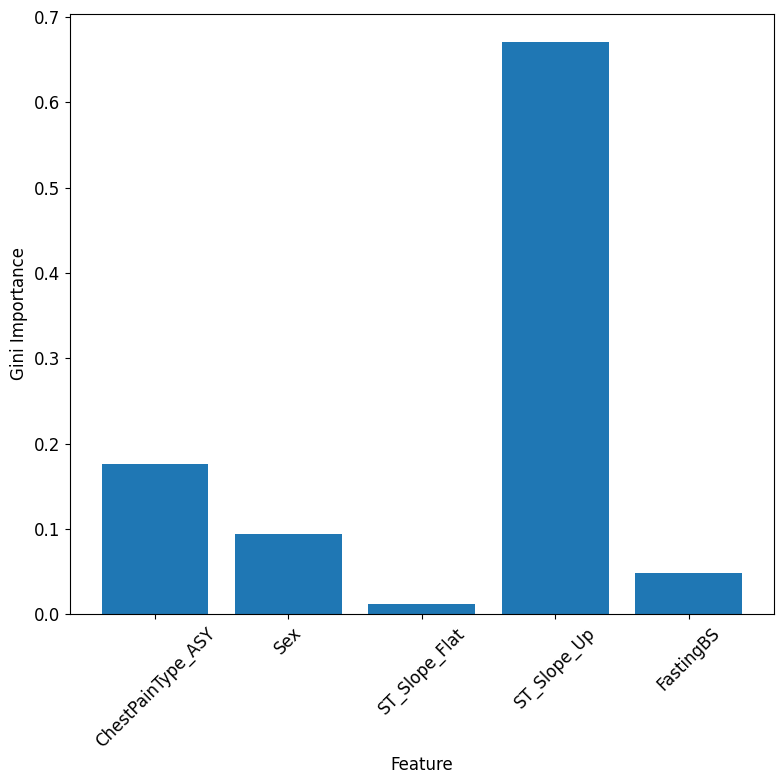

In [ ]:
plt.rc('font', size=12)

# visualize Gini importance of features
importance = clf.feature_importances_
feature_names = X_train_val_fs.columns

plt.figure(figsize=(8, 8))
plt.bar(feature_names, importance)
plt.xticks(rotation=45)
plt.xlabel("Feature")
plt.ylabel("Gini Importance")

plt.tight_layout()
plt.savefig('dtrees_feature_importance.png')

# Multilayer Perceptron

In [ ]:
!pip install lightning 

Pytorch lightning is a wrapper around pytorch that removes boilerplate code. It is great! It facilitates training including GPU/TPU and multinode training as well as logging, checkpointing etc.

In [15]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import os
import itertools
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

# set seed for repeatability
pl.seed_everything(42)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42


42

We first define the MLP model itself. It is build such that we can dynamically change the number of layers and the hidden dimensions.

In [16]:
class MLP(pl.LightningModule):
  def __init__(self, in_dim, hidden_dims, lr):
    """
    Initialises a MLP.

    Args:
      in_dim: Input dimension.
      hidden_dims: List of hidden dims. Will results in len(hidden_dims)-1 layers.
      lr: learning rate
    """
    super().__init__()
    assert len(hidden_dims) > 0

    # Build the network
    # Input layer
    self.layers = nn.Sequential(nn.Linear(in_dim, hidden_dims[0]), nn.ReLU())
    # Hidden layers
    for i, h_dim in enumerate(hidden_dims[1:]):
      self.layers.append(nn.Linear(hidden_dims[i], h_dim))
      self.layers.append(nn.ReLU())
    # Output layer
    self.layers.append(nn.Linear(hidden_dims[-1], 1))
    # Binary prediction -> We use a sigmoid act.
    self.layers.append(nn.Sigmoid()) 
    
    self.loss = nn.BCELoss()
    self.hparams.update({"lr": lr, "in_dim": in_dim, "hidden_dims": hidden_dims})
    self.save_hyperparameters()

  @staticmethod
  def calc_metrics(y, y_pred, stage):
      y_pred = y_pred.detach().cpu()
      y = y.cpu()
      y_pred_th = y_pred > 0.5
      # calculate f1 score and balanced accuracy
      f1 = f1_score(y, y_pred_th)
      ba = balanced_accuracy_score(y, y_pred_th)
      return {
          f"{stage}/f1": f1,
          f"{stage}/ba": ba
      }
    
  def forward(self, x):
    return self.layers(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch[:,:-1], batch[:,-1]
    loss = self.loss(self(x)[:, 0], y)
    self.log('train_loss', loss)
    return loss

  def validation_step(self, batch, batch_nb):
    x, y = batch[:,:-1], batch[:,-1]
    y_pred = self(x)[:, 0]
    loss = self.loss(y_pred, y)
    self.log_dict(MLP.calc_metrics(y,y_pred,"val"), on_step=False, on_epoch=True, prog_bar=True)
    return loss

  def test_step(self, batch, batch_nb):
    x, y = batch[:,:-1], batch[:,-1]
    y_pred = self(x)[:, 0]
    loss = self.loss(y_pred, y)
    self.log_dict(MLP.calc_metrics(y,y_pred,"test"), on_step=False, on_epoch=True, prog_bar=True)
    return loss

  def configure_optimizers(self):
    # We use adam with weight decay
    optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams["lr"])
    return optimizer
  

In a second step we define the Data Module that handles the data set and how the dataset is loaded.

In [17]:
class HeartDiseaseDataModule(pl.LightningDataModule):
  def __init__(self, name, X_train, y_train, X_val, y_val, X_test, y_test, batch_size=16):
    super().__init__()
    self.batch_size = batch_size
    self.X_train, self.y_train = X_train, y_train
    self.X_val, self.y_val = X_val, y_val
    self.X_test, self.y_test = X_test, y_test
    self.input_dimension = X_train.shape[1]
    self.name = name

  def prepare_data(self): 
    def to_values(data):
      if isinstance(data, pd.Series) or isinstance(data,pd.DataFrame):
        return data.values
      return data
    self.data_train = torch.Tensor(np.column_stack((to_values(self.X_train), to_values(self.y_train))))
    self.data_val = torch.Tensor(np.column_stack((to_values(self.X_val), to_values(self.y_val))))
    self.data_test = torch.Tensor(np.column_stack((to_values(self.X_test), to_values(self.y_test))))

  def train_dataloader(self):
    return DataLoader(self.data_train, batch_size=self.batch_size, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.data_val, batch_size=self.batch_size)

  def test_dataloader(self):
    return DataLoader(self.data_test, batch_size=self.batch_size)

Because of performance reasons we do not run cross validation for the MLP.

We create a train function that trains a model given the model size and the learning rate and saves the best model based on the balanced accuracy on the validation set (val/ba). We then use this train function to gridsearch optimal hyperparameters. Additionally we train the model twice, once with the feature selection to 5 features and once on the full cleaned feature set.

In [18]:
def train(data_module, layers, lr, epochs=50):
  run_name = f"{data_module.name}.{'-'.join([str(l) for l in layers])}.{lr}"
  print(f"Starting training of {run_name}.")
  # initiate mlp
  mlp = MLP(data_module.input_dimension, layers, lr)
  # setup logger
  logger = TensorBoardLogger("tb_logs", name=run_name)
  # Save the best model during training based on the val/ba score
  checkpoint_callback = ModelCheckpoint(dirpath="checkpoints", monitor="val/ba", mode="max", filename= run_name +'.{epoch}-{step}')
  # Create the lightning trainer
  trainer = pl.Trainer(max_epochs=epochs, log_every_n_steps=10, logger=logger, callbacks=[checkpoint_callback])
  # train the model
  trainer.fit(mlp, data_module)

  path = checkpoint_callback.best_model_path
  ba = checkpoint_callback.best_model_score
  print(f"################\n Finished training of {run_name}\n Balanced Acc: {ba}")
  return ba, path, mlp


In [ ]:
# First start the tensorboard to monitor training
%tensorboard --logdir tb_logs

### Feature Selected


In [ ]:
# clean up
!rm -r tb_logs checkpoints

^C


In [ ]:
# run grid search on the hyperparams below
epochs = 100
batch_sizes = [8, 16]
architectures = [[32], [16], [8], [16, 8], [32,16]]
learning_rates = [1e-3, 1e-4, 1e-5]

best_model_path = None
best_ba = 0
best_hyperparams = None

done, total = 0, len(architectures) * len(learning_rates) * len(batch_sizes)
for arch, lr, bs in itertools.product(architectures, learning_rates, batch_sizes):
  data_module = HeartDiseaseDataModule(f"fs_bs{bs}", X_train_fs, y_train,
                                     X_val_fs, y_val,
                                     X_test_fs, y_test,
                                     bs)
  ba, path, mlp = train(data_module, arch, lr, epochs=epochs)
  # if this configuration is better than previous ones, we save it
  if ba > best_ba:
    best_ba, best_model_path = ba, path
    best_hyperparams = (arch, lr, bs)
  done += 1
  print(f"Progress: {done}/{total}")

In [ ]:
print("####################")
print("Gird Search Results:")
print("Best model:", best_model_path)
print(f"Layers: {best_hyperparams[0]} – LR: {best_hyperparams[1]} - BS {best_hyperparams[2]}")
print("Best balanced accuracy:", best_ba)
print("####################")

In [ ]:
"""
####################
Gird Search Results:
Best model: /content/drive/MyDrive/ML4HC/project1/part1/checkpoints/fs_bs16.8.0.001.epoch=6-step=259-v1.ckpt
Layers: [8] – LR: 0.001 - BS 16
Best balanced accuracy: tensor(0.8767, device='cuda:0', dtype=torch.float64)
####################
"""
best_model_path = "/content/drive/MyDrive/ML4HC/project1/part1/checkpoints/fs_bs16.8.0.001.epoch=6-step=259-v1.ckpt"
best_bs = 16

In [ ]:
print("Reevaluating best model")

best_model = MLP.load_from_checkpoint(best_model_path)
data_module = HeartDiseaseDataModule(f"fs_bs{best_bs}", X_train_fs, y_train,
                                     X_val_fs, y_val,
                                     X_test_fs, y_test,
                                     best_bs)
trainer = pl.Trainer()
val_results = trainer.validate(best_model, data_module)
val_results

In [ ]:
test_results = trainer.test(best_model, data_module)
test_results

### Full Cleaned Feature Set

In [20]:

# run grid search on the hyperparams below
excluded_features =  ["Cholesterol", "has_cholesterol"]

X_train_cleaned = X_train.drop(columns=excluded_features).copy()
X_val_cleaned = X_val.drop(columns=excluded_features).copy()
X_test_cleaned = X_test.drop(columns=excluded_features).copy()

In [ ]:
epochs = 100
batch_sizes = [8, 16]
architectures = [[32], [16], [8], [16, 8], [32,16]]
learning_rates = [1e-3, 1e-4, 1e-5]


best_model_path_full = None
best_ba_full = 0
best_hyperparams_full = None

done, total = 0, len(architectures) * len(learning_rates) * len(batch_sizes)
for arch, lr, bs in itertools.product(architectures, learning_rates, batch_sizes):
  data_module = HeartDiseaseDataModule(f"cl_bs{bs}", X_train_cleaned, y_train,
                                     X_val_cleaned, y_val,
                                     X_test_cleaned, y_test,
                                     bs)

  ba, path, mlp = train(data_module, arch, lr, epochs=epochs)
  # if this configuration is better than previous ones, we save it
  if ba > best_ba_full:
    best_ba_full, best_model_path_full = ba, path
    best_hyperparams_full = (arch, lr, bs)
  done += 1
  print(f"Progress: {done}/{total} – best ", best_model_path_full)

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


################
 Finished training of fs_bs8.32-16.1e-05
 Balanced Acc: 0.835827664399093
Progress: 29/30 – best  /content/drive/MyDrive/ML4HC/project1/part1/checkpoints/fs_bs16.16-8.0.0001.epoch=38-step=1443.ckpt
Starting training of fs_bs16.32-16.1e-05.


/usr/local/lib/python3.9/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/drive/MyDrive/ML4HC/project1/part1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 1.2 K 
1 | loss   | BCELoss    | 0     
--------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 1.2 K 
1 | loss   | BCELoss    | 0     
--------------------------------------
1.2 K     Trainable params
0         Non-train

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


################
 Finished training of fs_bs16.32-16.1e-05
 Balanced Acc: 0.8353054353054353
Progress: 30/30 – best  /content/drive/MyDrive/ML4HC/project1/part1/checkpoints/fs_bs16.16-8.0.0001.epoch=38-step=1443.ckpt


In [ ]:
print("####################")
print("Gird Search Results:")
print("Best model:", best_model_path_full)
print(f"Layers: {best_hyperparams_full[0]} – LR: {best_hyperparams_full[1]} - BS {best_hyperparams_full[2]})")
print("Best balanced accuracy:", best_ba_full)
print("####################")


In [39]:
"""
Gird Search Results:
Best model: /content/drive/MyDrive/ML4HC/project1/part1/checkpoints/cl_bs16.16-8.0.0001.epoch=47-step=1776.ckpt
Layers: [32, 16] – LR: 1e-05 - BS 16
Best balanced accuracy: tensor(0.8774, device='cuda:0', dtype=torch.float64)
"""
best_model_path_full = "/content/drive/MyDrive/ML4HC/project1/part1/checkpoints/cl_bs16.16-8.0.0001.epoch=47-step=1776.ckpt"
best_bs = 16

In [68]:
"""
####################
Gird Search Results:
Best model: /content/drive/MyDrive/ML4HC/project1/part1/checkpoints/cl_bs16.16-8.0.0001.epoch=46-step=1739.ckpt
Layers: [16, 8] – LR: 0.0001 - BS 16)
Best balanced accuracy: tensor(0.8864, device='cuda:0', dtype=torch.float64)
####################
"""
best_model_path_full = "/content/drive/MyDrive/ML4HC/project1/part1/checkpoints/cl_bs16.16-8.0.0001.epoch=46-step=1739.ckpt"
best_bs = 16

In [69]:
trainer = pl.Trainer(max_epochs=100)
best_model = MLP.load_from_checkpoint(best_model_path_full)
val_results = trainer.validate(best_model, data_module)
val_results

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val/ba           │    0.8690186608553955     │
│          val/f1           │    0.8693905418978972     │
└───────────────────────────┴───────────────────────────┘

[{'val/f1': 0.8693905418978972, 'val/ba': 0.8690186608553955}]

In [70]:
test_results = trainer.test(best_model, data_module)
test_results

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test/ba          │    0.8126701800614843     │
│          test/f1          │    0.8533452111384072     │
└───────────────────────────┴───────────────────────────┘

[{'test/f1': 0.8533452111384072, 'test/ba': 0.8126701800614843}]

# Shapley Values

In [ ]:
!pip install shap

In [71]:
import shap

# load best model trained on full feature set
mlp = best_model

# Background is the training data
background = torch.Tensor(X_train_cleaned.values)

# compute the SHAP values for the linear model
explainer = shap.DeepExplainer(mlp, background)

In [72]:
shap_values = explainer.shap_values(torch.Tensor(X_val_cleaned.values))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [73]:
shap_values.shape

(147, 18)

## Global Interpretation

4 out of 5 correspond

In [74]:
# features selected with Lasse
features

['ChestPainType_ASY', 'Sex', 'ST_Slope_Flat', 'ST_Slope_Up', 'FastingBS']

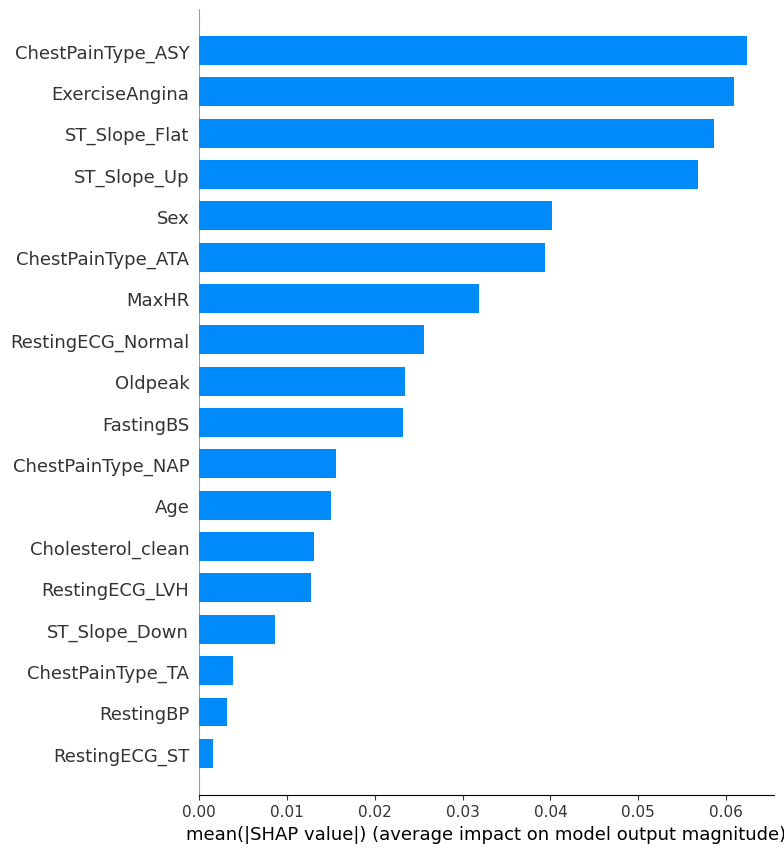

In [75]:
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = X_train_cleaned.columns)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


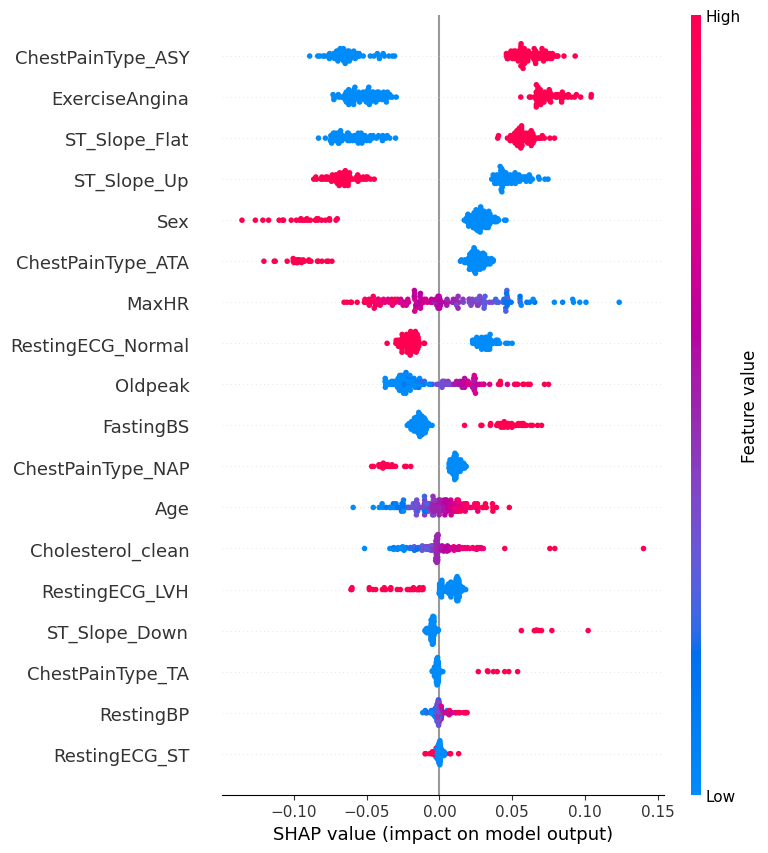

In [85]:
shap.summary_plot(shap_values, torch.Tensor(X_val_cleaned.values), feature_names = X_train_cleaned.columns)

## Local Interpretation

We have deleted the JS plots from the notebook as they are making problems when reopening the notebook.

In [86]:
y_val_reset = y_val.reset_index(drop=True)

In [87]:
positive_samples = y_val_reset[y_val_reset == 1].sample(4).index
negative_samples = y_val_reset[y_val_reset == 0].sample(4).index

### Positive Samples

In [ ]:
i = 0
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[positive_samples[i]], features = X_train_cleaned.columns)

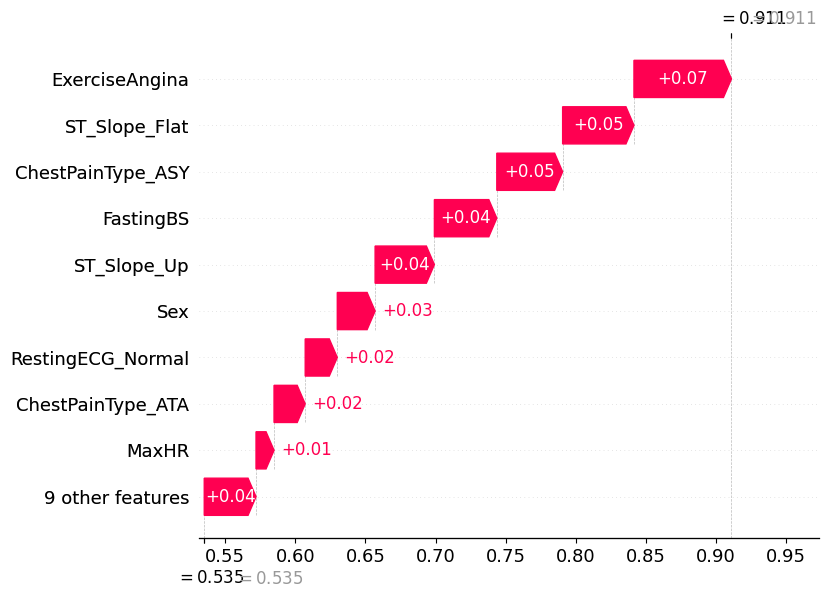

In [89]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[positive_samples[i]], feature_names = X_train_cleaned.columns)

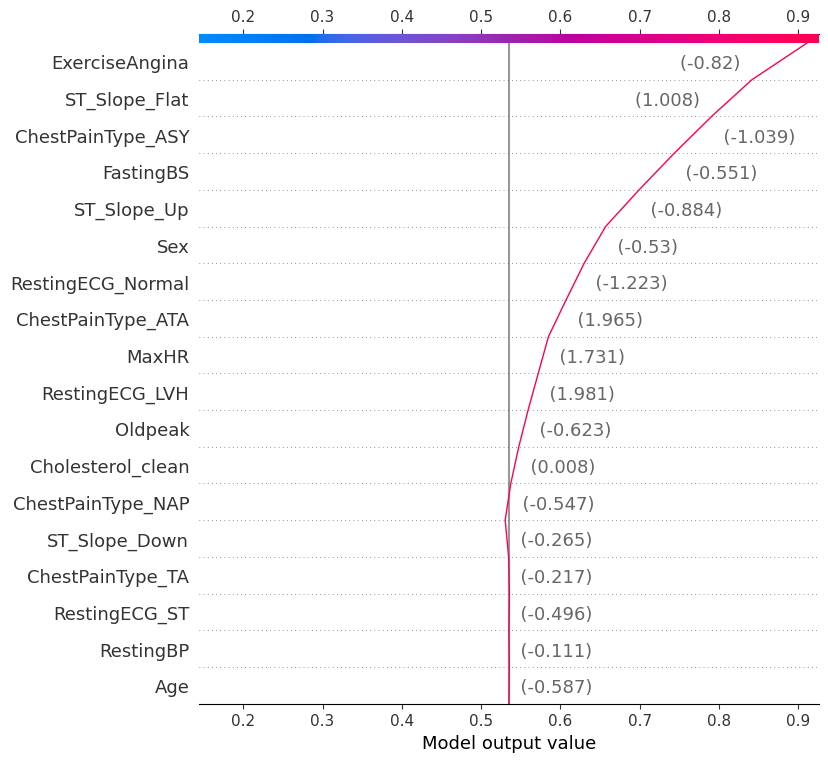

In [90]:
shap.decision_plot(explainer.expected_value[0], shap_values[positive_samples[i]], features = X_train_cleaned.iloc[0,:], feature_names = X_train_cleaned.columns.tolist())

In [ ]:
i = 1
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[positive_samples[i]], features = X_train_cleaned.columns)

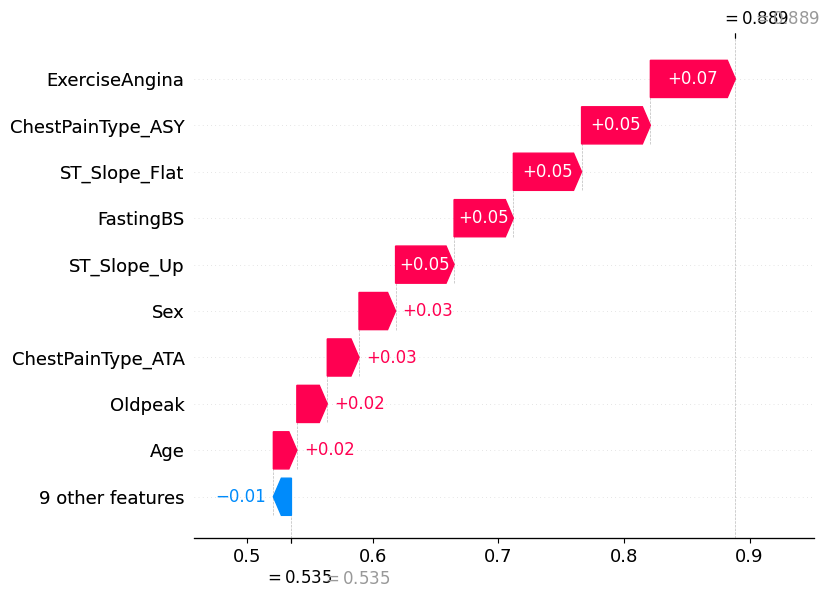

In [101]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[positive_samples[i]], feature_names = X_train_cleaned.columns)

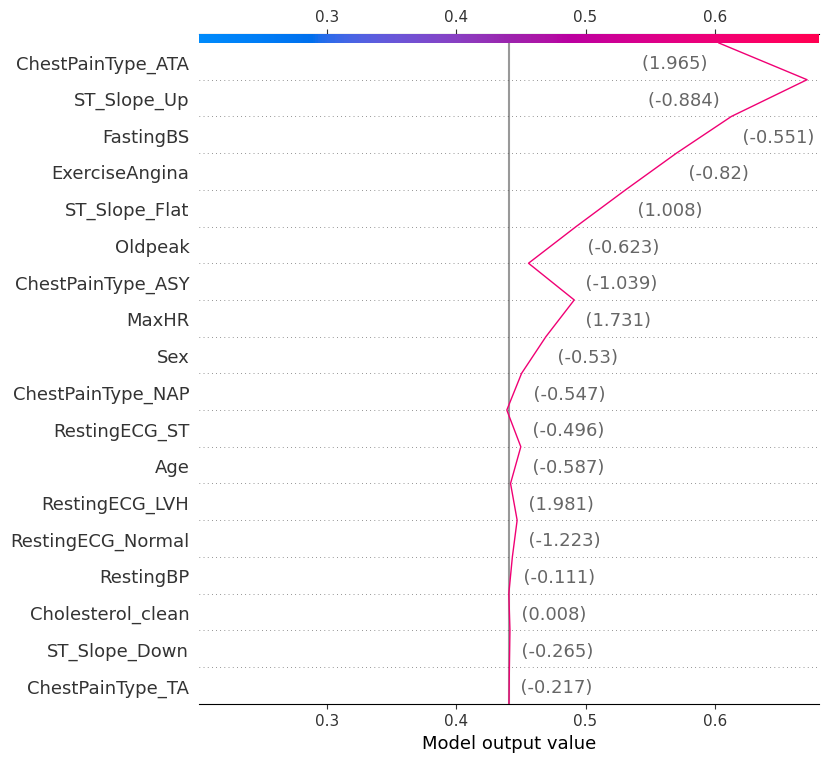

In [ ]:
shap.decision_plot(explainer.expected_value[0], shap_values[positive_samples[i]], features = X_train_cleaned.iloc[0,:], feature_names = X_train_cleaned.columns.tolist())

In [ ]:
i = 2
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[positive_samples[i]], features = X_train_cleaned.columns)

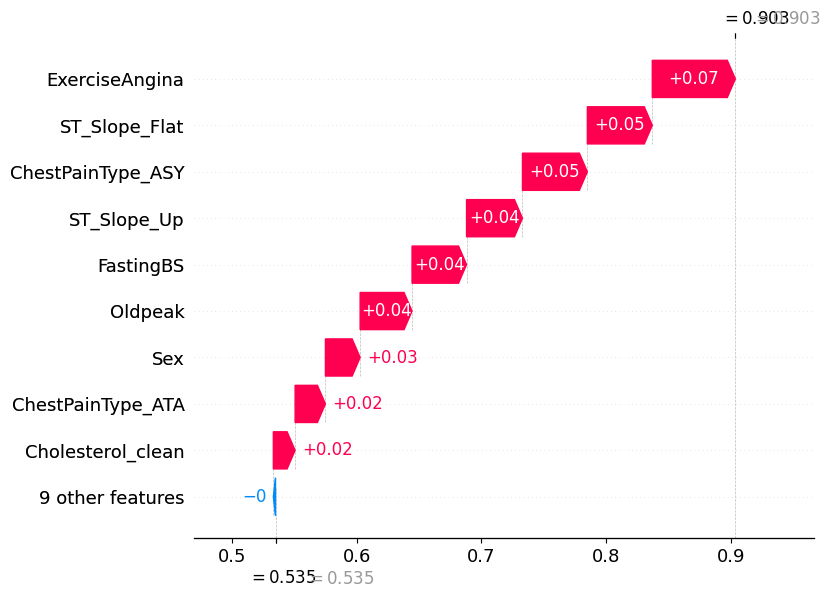

In [103]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[positive_samples[i]], feature_names = X_train_cleaned.columns)

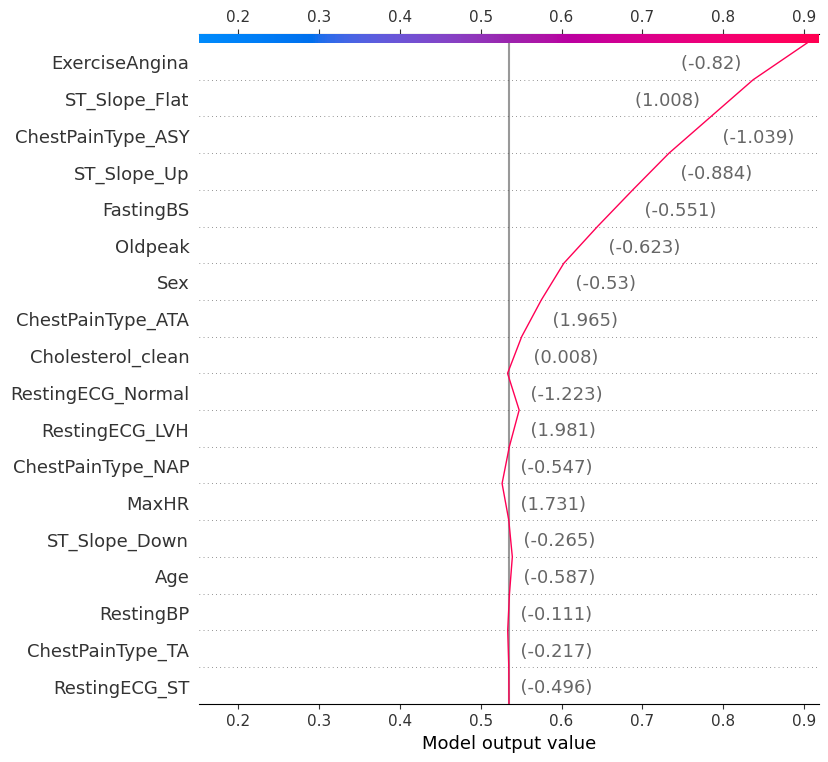

In [104]:
shap.decision_plot(explainer.expected_value[0], shap_values[positive_samples[i]], features = X_train_cleaned.iloc[0,:], feature_names = X_train_cleaned.columns.tolist())

In [ ]:
i = 3
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[positive_samples[i]], features = X_train_cleaned.columns)

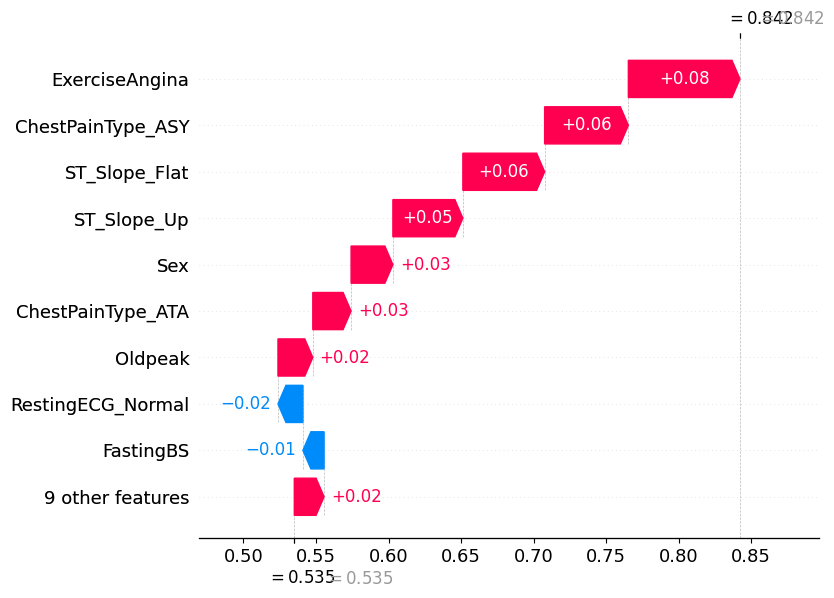

In [106]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[positive_samples[i]], feature_names = X_train_cleaned.columns)

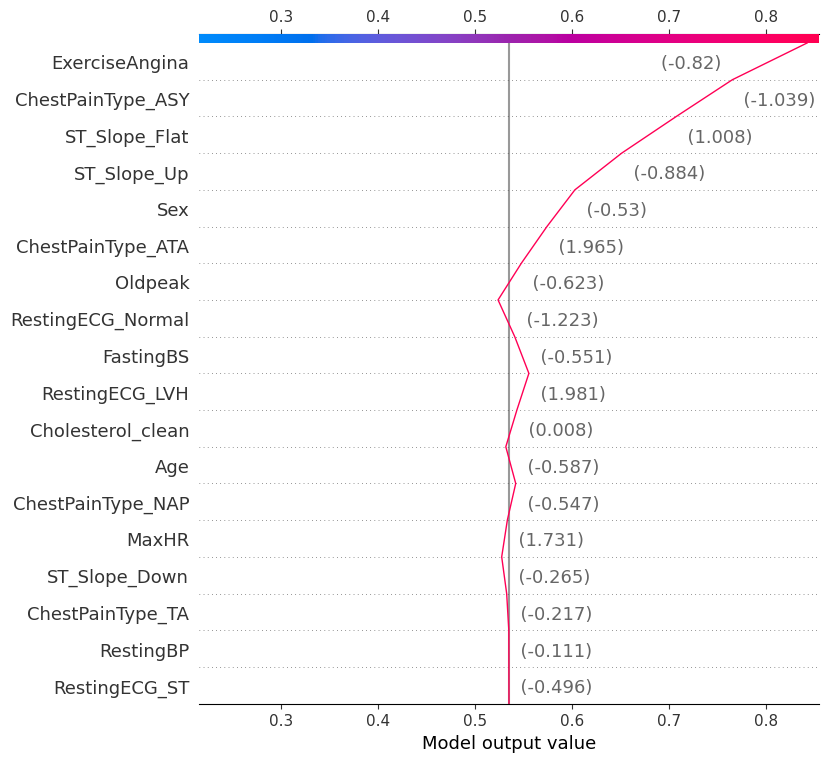

In [107]:
shap.decision_plot(explainer.expected_value[0], shap_values[positive_samples[i]], features = X_train_cleaned.iloc[0,:], feature_names = X_train_cleaned.columns.tolist())

### Negative Samples

In [ ]:
i = 0
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[negative_samples[i]], features = X_train_cleaned.columns)

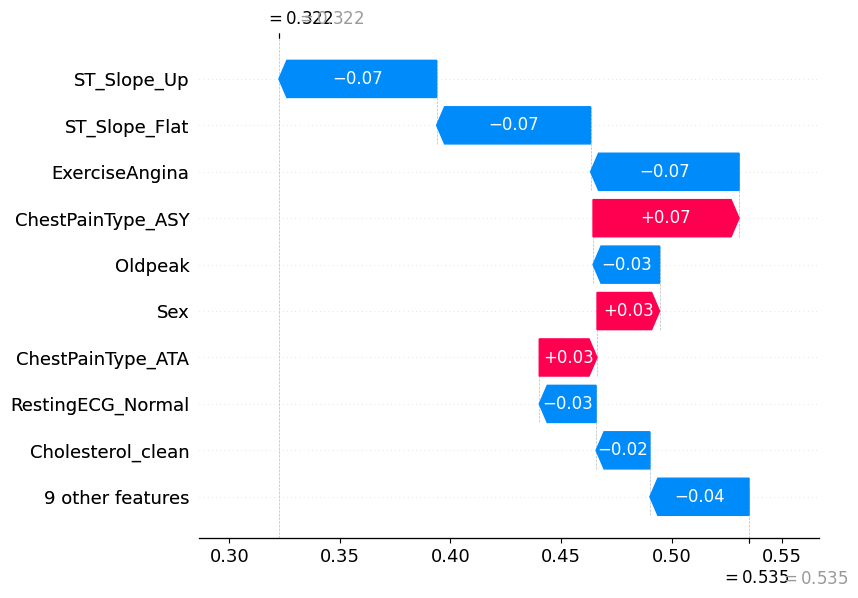

In [109]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[negative_samples[i]], feature_names = X_train_cleaned.columns)

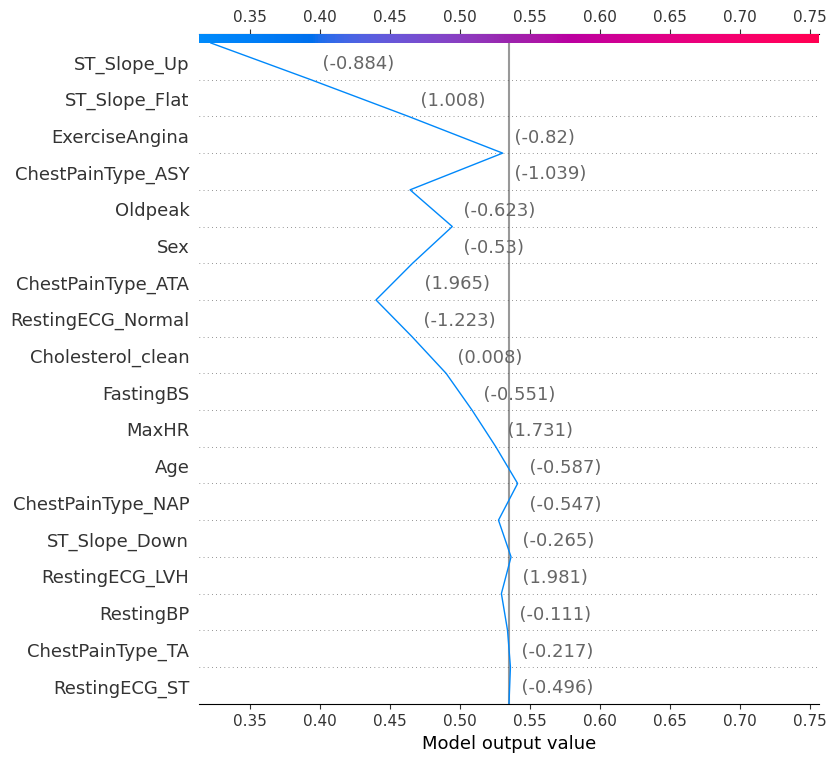

In [110]:
shap.decision_plot(explainer.expected_value[0], shap_values[negative_samples[i]], features = X_train_cleaned.iloc[0,:], feature_names = X_train_cleaned.columns.tolist())

In [ ]:
i = 1
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[negative_samples[i]], features = X_train_cleaned.columns)

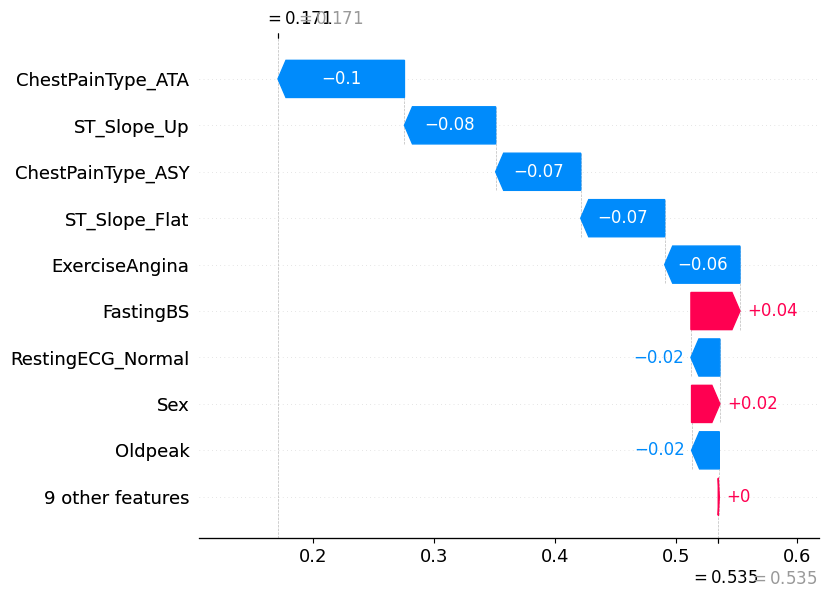

In [112]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[negative_samples[i]], feature_names = X_train_cleaned.columns)

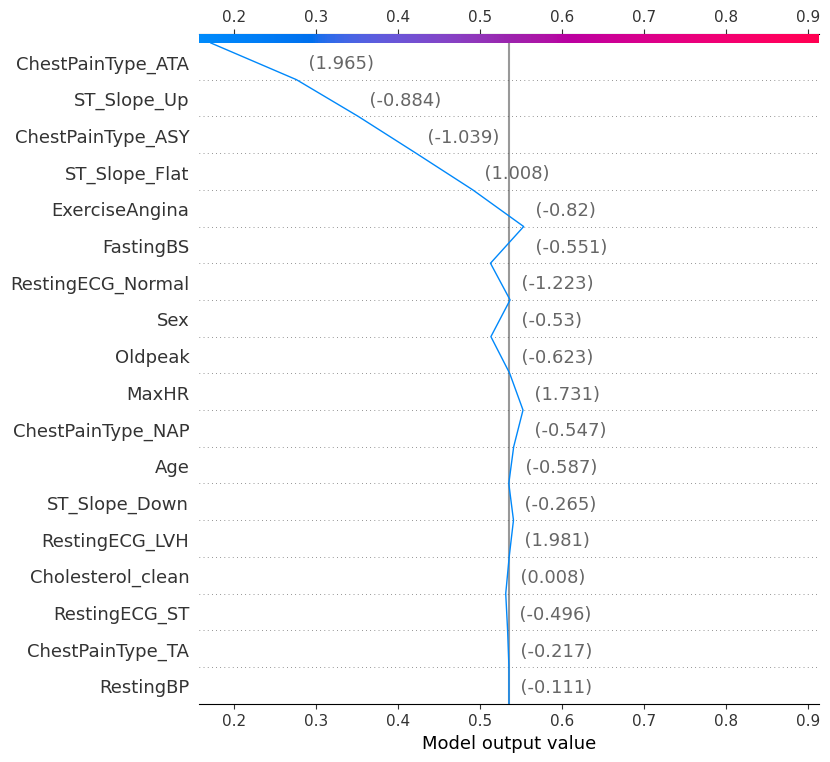

In [113]:
shap.decision_plot(explainer.expected_value[0], shap_values[negative_samples[i]], features = X_train_cleaned.iloc[0,:], feature_names = X_train_cleaned.columns.tolist())

In [114]:
i = 2
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[negative_samples[i]], features = X_train_cleaned.columns)

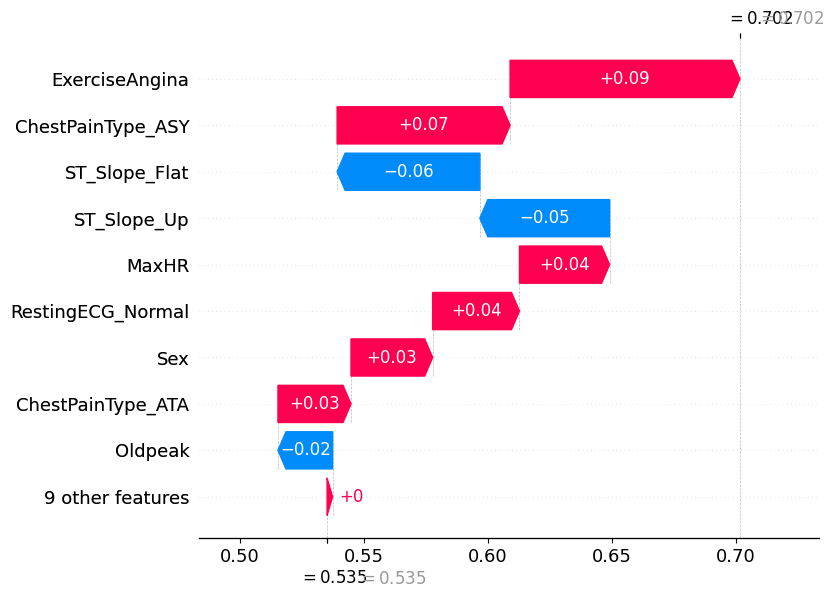

In [115]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[negative_samples[i]], feature_names = X_train_cleaned.columns)

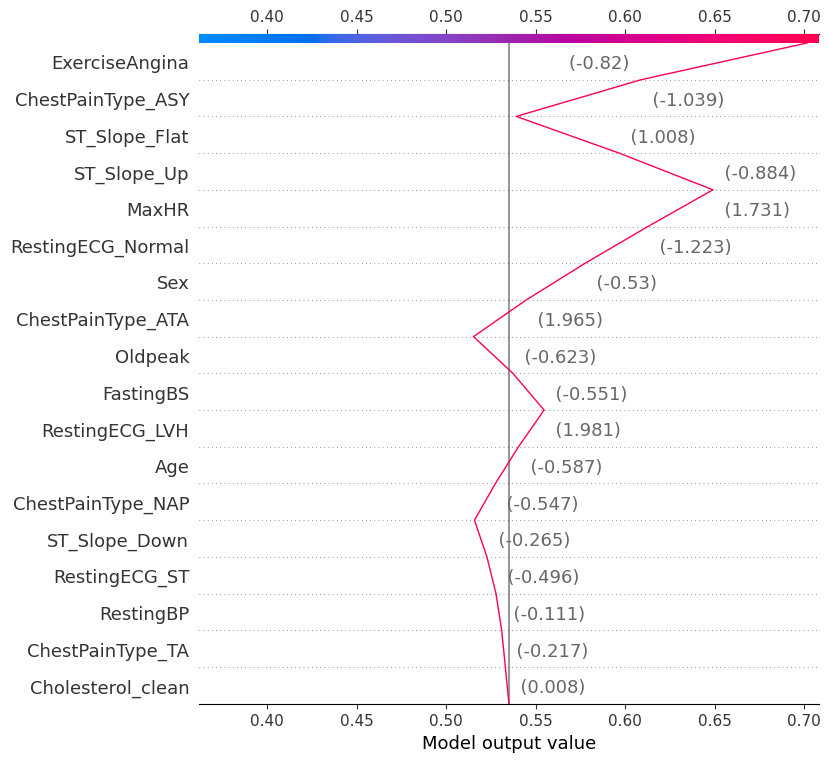

In [116]:
shap.decision_plot(explainer.expected_value[0], shap_values[negative_samples[i]], features = X_train_cleaned.iloc[0,:], feature_names = X_train_cleaned.columns.tolist())

In [117]:
i = 3
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[negative_samples[i]], features = X_train_cleaned.columns)

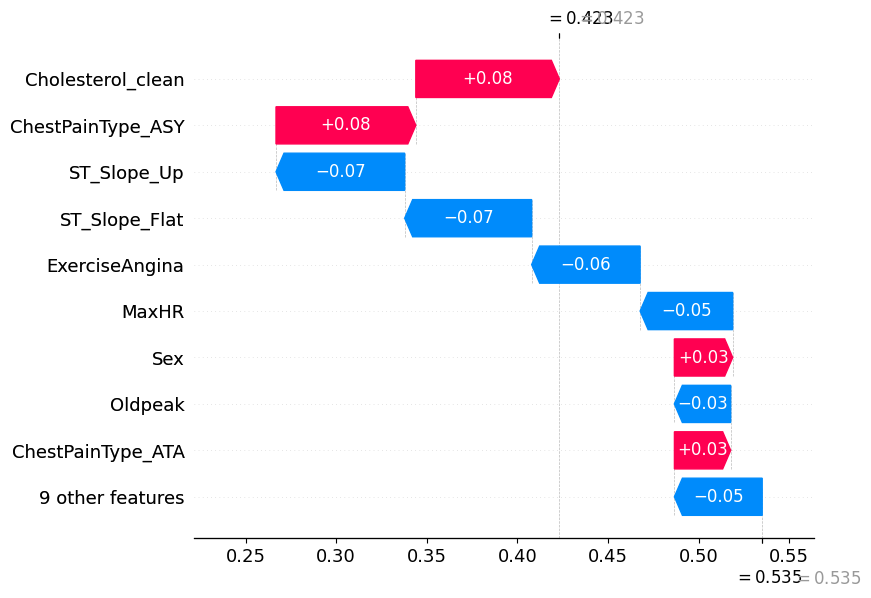

In [118]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[negative_samples[i]], feature_names = X_train_cleaned.columns)

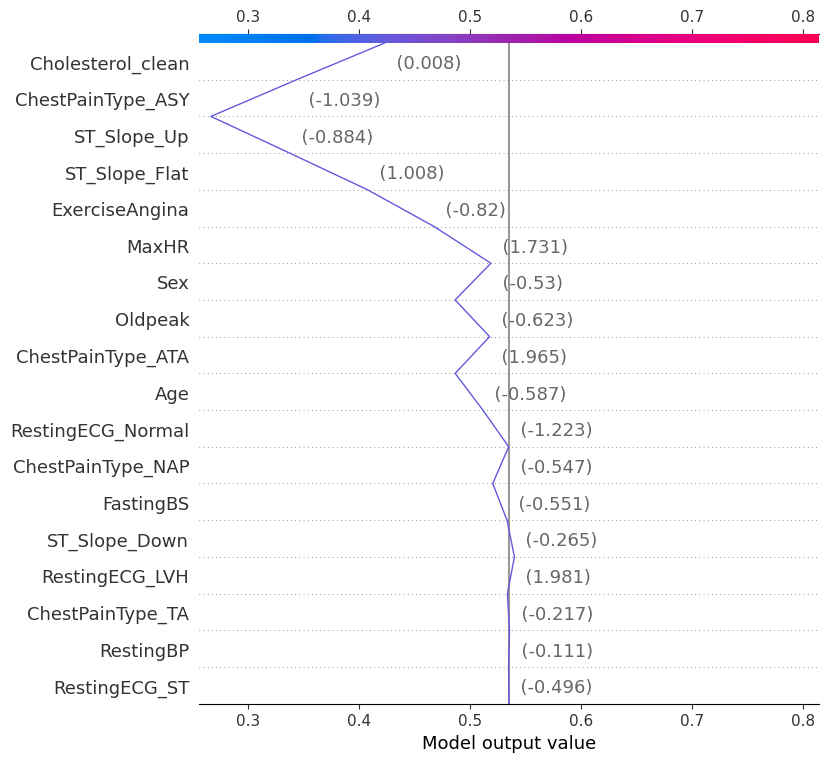

In [119]:
shap.decision_plot(explainer.expected_value[0], shap_values[negative_samples[i]], features = X_train_cleaned.iloc[0,:], feature_names = X_train_cleaned.columns.tolist())